In [3]:
import sys
sys.path.append("estimators")
sys.path.append("simulations")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [8]:
10**(-0.1)

0.7943282347242815

In [11]:
np.log10(4*0.2)

np.float64(-0.09691001300805639)

In [5]:
np.var(np.ones((2, 5)), axis=0, ddof=1)

array([0., 0., 0., 0., 0.])

In [2]:
from generation import *
from estimators_RKHS import *

In [7]:
np.logspace(-6, -0.1, num=50)

array([1.00000000e-06, 1.31949626e-06, 1.74107038e-06, 2.29733585e-06,
       3.03132606e-06, 3.99982340e-06, 5.27775201e-06, 6.96397403e-06,
       9.18893768e-06, 1.21247689e-05, 1.59985872e-05, 2.11100760e-05,
       2.78546663e-05, 3.67541279e-05, 4.84969343e-05, 6.39915234e-05,
       8.44365757e-05, 1.11413746e-04, 1.47010021e-04, 1.93979172e-04,
       2.55954792e-04, 3.37731391e-04, 4.45635307e-04, 5.88014120e-04,
       7.75882432e-04, 1.02377397e-03, 1.35086592e-03, 1.78246253e-03,
       2.35195264e-03, 3.10339270e-03, 4.09491506e-03, 5.40322511e-03,
       7.12953531e-03, 9.40739518e-03, 1.24130227e-02, 1.63789371e-02,
       2.16119462e-02, 2.85168821e-02, 3.76279193e-02, 4.96498988e-02,
       6.55128557e-02, 8.64439680e-02, 1.14062492e-01, 1.50505032e-01,
       1.98590827e-01, 2.62039853e-01, 3.45760606e-01, 4.56229826e-01,
       6.01993548e-01, 7.94328235e-01])

In [ ]:
def compute_results(n_target):
    # gamma_seq = np.logspace(-6, -0.1, num=100)
    gamma_seq = np.logspace(-6, -0.1, num=100)
    gen_params = {
        'p' :5,
        'beta': 1, 
        'n_plus': 150,
        'n_minus': 150,
        'n_target': n_target,
        'pi_target': 0.75
    }
    results_grid = []
    N = 100

    df_results_emp = pd.DataFrame(np.zeros((N*len(gamma_seq), 8)), 
                          columns=['pi_ipr','pi_ipr_V', 'pi_nrm','var_n', 'var', 'seed', 'gamma', 'var_rbf'])
    iter = 0

    df_results = pd.DataFrame(np.zeros((N, 10)), 
                          columns=['gamma_numerical', 'gamma_numerical_V', 'gamma_grid', 'gamma_grid_V',
                                   'gamma_bootstrap_var', 'gamma_bootstrap_var_V', 'gamma_bootstrap_mse', 'gamma_bootstrap_mse_V',
                                   'gamma_distance', 'gamma_distance_V'])
    
    for i in tqdm(range(N)):
        p_source_plus, p_source_minus, p_target = generate_sample_Nstd_Nstd_CC(**gen_params, seed=i)
        for gamma in gamma_seq:
            
            mod = estimator_RHKS(p_target, p_source_plus, p_source_minus, kernel_params={'gamma': gamma})
            mod.compute_basic_simulations()

            df_results_emp.loc[iter, 'pi_ipr'] = mod.pi_ipr
            df_results_emp.loc[iter, 'pi_nrm'] =  mod.pi_nrm
            df_results_emp.loc[iter, 'var_n'] = mod.var_plug_in_n
            df_results_emp.loc[iter, 'var'] = mod.var_plug_in
            df_results_emp.loc[iter, 'seed'] = i
            df_results_emp.loc[iter, 'gamma'] =  gamma
            df_results_emp.loc[iter, 'var_rbf'] = generate_sample_Nstd_Nstd_CC_rbf(**gen_params, gamma=gamma)[0]*mod.r_n

            mod = estimator_RHKS(p_target, p_source_plus, p_source_minus, kernel_params={'gamma': gamma}, UorV_statistic='V')
            mod.compute_basic_simulations()
            df_results_emp.loc[iter, 'pi_ipr_V'] = mod.pi_ipr


            iter = iter + 1
        mod = estimator_RHKS_rbf_gamma(p_target, p_source_plus, p_source_minus, how='numerical')
        mod.compute_basic_simulations()
        df_results.loc[i, 'gamma_numerical'] = mod.gamma_opt

        mod = estimator_RHKS_rbf_gamma(p_target, p_source_plus, p_source_minus, how='numerical_V')
        mod.compute_basic_simulations()
        df_results.loc[i, 'gamma_numerical_V'] = mod.gamma_opt
        
        mod = estimator_RHKS_rbf_gamma(p_target, p_source_plus, p_source_minus, how='grid')
        mod.compute_basic_simulations()
        df_results.loc[i, 'gamma_grid'] = mod.gamma_opt
        results_grid.append({**mod.opt_values,
                             'model': 'grid',
                             'seed': i})

        mod = estimator_RHKS_rbf_gamma(p_target, p_source_plus, p_source_minus, how='grid_V')
        mod.compute_basic_simulations()
        df_results.loc[i, 'gamma_grid_V'] = mod.gamma_opt
        results_grid.append({**mod.opt_values,
                             'model': 'grid_V',
                             'seed': i})

        mod = estimator_RHKS_rbf_gamma(p_target, p_source_plus, p_source_minus, how='bootstrap_var')
        mod.compute_basic_simulations()
        df_results.loc[i, 'gamma_bootstrap_var'] = mod.gamma_opt
        results_grid.append({**mod.opt_values,
                             'model': 'bootstrap_var',
                             'seed': i})
        
        mod = estimator_RHKS_rbf_gamma(p_target, p_source_plus, p_source_minus, how='bootstrap_var_V')
        mod.compute_basic_simulations()
        df_results.loc[i, 'gamma_bootstrap_var_V'] = mod.gamma_opt
        results_grid.append({**mod.opt_values,
                             'model': 'bootstrap_var_V',
                             'seed': i})
        
        mod = estimator_RHKS_rbf_gamma(p_target, p_source_plus, p_source_minus, how='bootstrap_mse')
        mod.compute_basic_simulations()
        df_results.loc[i, 'gamma_bootstrap_mse'] = mod.gamma_opt
        results_grid.append({**mod.opt_values,
                             'model': 'bootstrap_mse',
                             'seed': i})
        
        mod = estimator_RHKS_rbf_gamma(p_target, p_source_plus, p_source_minus, how='bootstrap_mse_V')
        mod.compute_basic_simulations()
        df_results.loc[i, 'gamma_bootstrap_mse_V'] = mod.gamma_opt
        results_grid.append({**mod.opt_values,
                             'model': 'bootstrap_mse_V',
                             'seed': i})
        
        mod = estimator_RHKS_rbf_gamma(p_target, p_source_plus, p_source_minus, how='distance')
        mod.compute_basic_simulations()
        df_results.loc[i, 'gamma_distance'] = mod.gamma_opt
        results_grid.append({**mod.opt_values,
                             'model': 'distance',
                             'seed': i})
        
        mod = estimator_RHKS_rbf_gamma(p_target, p_source_plus, p_source_minus, how='distance_V')
        mod.compute_basic_simulations()
        df_results.loc[i, 'gamma_distance_V'] = mod.gamma_opt
        results_grid.append({**mod.opt_values,
                             'model': 'distance_V',
                             'seed': i})

    df_results_emp['MSE'] = (df_results_emp['pi_ipr'] - gen_params['pi_target'])**2
    df_results_emp['MSE_V'] = (df_results_emp['pi_ipr_V'] - gen_params['pi_target'])**2

    df1 = df_results_emp[['gamma', 'MSE']].groupby('gamma').aggregate('mean').reset_index()
    df1V = df_results_emp[['gamma', 'MSE_V']].groupby('gamma').aggregate('mean').reset_index()
    # df1['RMSE_div20'] = np.sqrt(df1['MSE'])/20
    df2 = df_results_emp[['gamma', 'pi_ipr']].groupby('gamma').aggregate(lambda s: s.var(ddof=0)).reset_index()
    df2.rename(columns={df2.columns[1]: "var_emp"}, inplace=True)
    df3 = df_results_emp[['gamma', 'var_n']].groupby('gamma').aggregate('mean').reset_index()
    df3.rename(columns={df3.columns[1]: "est_var_as"}, inplace=True)
    df4 = df_results_emp[['gamma', 'var_rbf']].groupby('gamma').aggregate('mean').reset_index()
    df1 = df1.merge(df1V, on='gamma')
    df = df1.merge(df2, on='gamma')
    df = df.merge(df3, on='gamma')
    df = df.merge(df4, on='gamma')

    return df_results_emp, df_results, df, results_grid

In [5]:
df_results_emp_list = []
df_results_list = []
df_list = []
df_gamma_seq_list=[]
for n_target in [100, 200, 300, 400, 500]:
    df_results_emp, df_results, df, results_grid = compute_results(n_target)
    df_results_emp_list.append(df_results_emp)
    df_results_list.append(df_results)
    df_list.append(df)
    df_gamma_seq = pd.DataFrame(results_grid)
    df_gamma_seq = df_gamma_seq.explode(["gamma", "values"], ignore_index=True)
    df_gamma_seq_list.append(df_gamma_seq)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [1:25:18<00:00, 51.18s/it]


In [6]:
import dill
all_results = {"df_results_emp_list": df_results_emp_list, 
               "df_results_list": df_results_list, 
               "df_list": df_list,
               "df_gamma_seq_list": df_gamma_seq_list}

with open("results_gamma_v2.dill", "wb") as f:
    dill.dump(all_results, f)

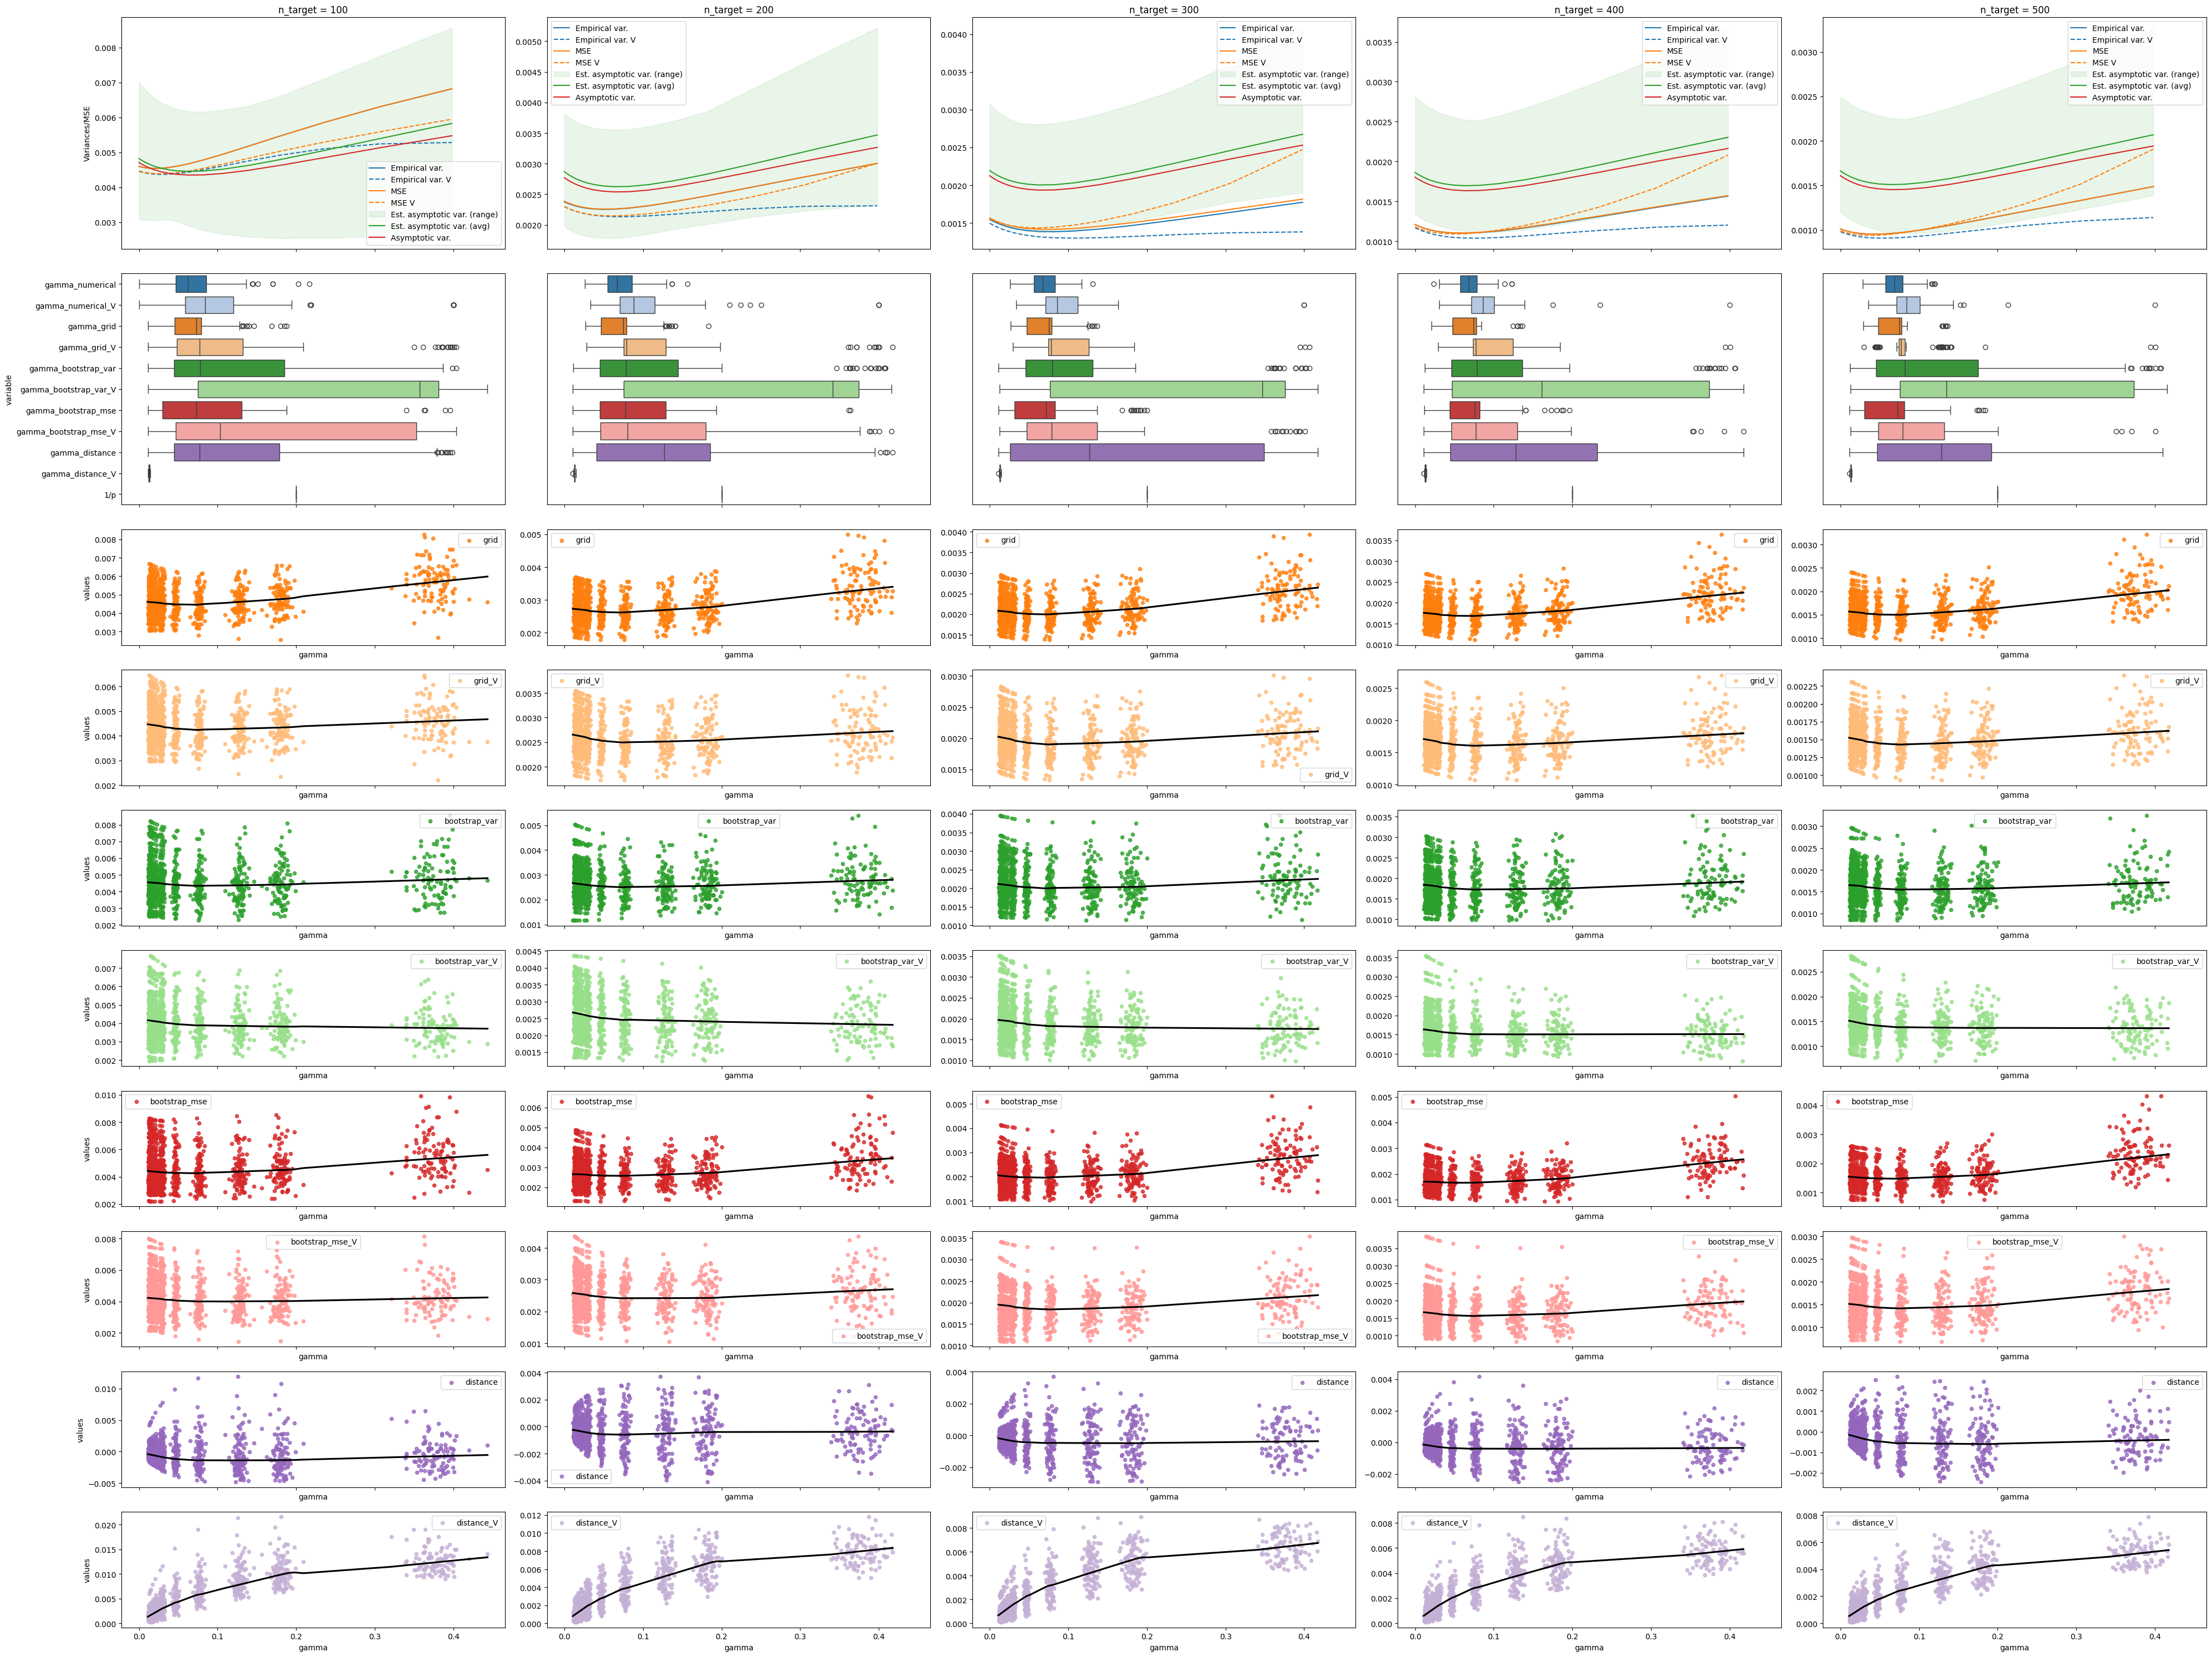

In [7]:
fig, axes = plt.subplots(10, 5, sharex=True, figsize=(40, 30), height_ratios=[2, 2] + [1]*8  )

for i in range(5):
    gamma_seq = np.sort(df_results_emp_list[i]['gamma'].unique().tolist())
    df_results_emp = df_results_emp_list[i]
    df_results = df_results_list[i]
    df = df_list[i]
    df_gamma_seq = df_gamma_seq_list[i]
    df_tmp_boxplot = df_results_list[i].melt(var_name="variable", value_name="value", ignore_index=True)
    n_target = [100,200,300,400,500][i]
    # First plot
    df2 = df_results_emp[['gamma', 'pi_ipr']].groupby('gamma').aggregate(lambda s: s.var(ddof=0)).reset_index()
    df2.rename(columns={df2.columns[1]: "var_emp"}, inplace=True)
    axes[0, i].plot(df2['gamma'], df2['var_emp'], label='Empirical var.')
    df2 = df_results_emp[['gamma', 'pi_ipr_V']].groupby('gamma').aggregate(lambda s: s.var(ddof=0)).reset_index()
    df2.rename(columns={df2.columns[1]: "var_emp"}, inplace=True)
    axes[0, i].plot(df2['gamma'], df2['var_emp'], label='Empirical var. V', color='C0', linestyle='dashed')
    axes[0, i].plot(df['gamma'], df['MSE'], label='MSE')
    axes[0, i].plot(df['gamma'], df['MSE_V'], label='MSE V', color='C1', linestyle='dashed')
    df3 = df_results_emp[['gamma', 'var_n']].groupby('gamma').aggregate(['mean', 'min', 'max']).reset_index()
    axes[0, i].fill_between(df3['gamma'], df3['var_n']['min'], df3['var_n']['max'], label='Est. asymptotic var. (range)', 
                            color='C2', alpha=0.1)
    axes[0, i].plot(df3['gamma'], df3['var_n']['mean'], label='Est. asymptotic var. (avg)')
    axes[0, i].plot(df['gamma'], df['var_rbf'], label='Asymptotic var.')
    # axes[0, i].vlines(x=0.2, ymin=np.min(df['var_emp']), ymax=np.max(df['var_emp']), color='C4')
    axes[0, i].legend()
    axes[0, i].set_ylabel("Variances/MSE")
    axes[0, i].set_title('n_target = '+str(n_target))

    # Second plot (histogram)
    df_tmp_boxplot.loc[len(df_tmp_boxplot)] = ["1/p", 0.2]
    sns.boxplot(df_tmp_boxplot, x='value', y='variable', hue='variable', ax=axes[1,i], palette='tab20')
    # axes[1,i].boxplot(df_tmp_boxplot)
    # axes[1,i].set_xlim(gamma_seq[0], gamma_seq[-1])
    # axes[1,i].set_xlabel("Gamma")
    # axes[1,i].set_ylabel("Count")
    # axes[1,i].set_title('gamma numerical')
    cmap = plt.get_cmap("tab20")
    for j, model in enumerate(df_gamma_seq['model'].unique()):
        # sns.scatterplot(df_gamma_seq[df_gamma_seq['model']==model], x='gamma', y='values', hue='model', ax=axes[2+j,i])
        sns.regplot(df_gamma_seq[df_gamma_seq['model']==model], x='gamma', y='values', label=model,
                    lowess=True, scatter_kws={"s":20, 'color':cmap(j+2)}, line_kws={"color":"black"}, ax=axes[2+j,i])
        axes[2+j,i].legend()
    
    # for j in range(10):
    if i > 0:
        axes[1, i].set_yticks([])
    for j in range(10):
        if i > 0:
            axes[j, i].set_ylabel('')

plt.tight_layout()
plt.show()